# Extracting an "assistant vector" from Llama 3

In [1]:
from lmexp.models.implementations.llama3 import Llama3Tokenizer, SteerableLlama3
from lmexp.generic.get_locations import all_tokens, at_search_tokens
from lmexp.generic.activation_steering.steering_approaches import (
    add_multiplier,
)
from lmexp.generic.activation_steering.steerable_model import SteeringConfig
import torch
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

## Loading the dataset

In [2]:
current_dir = os.getcwd()
with open(os.path.join(current_dir, "..", "datasets", "llama_user_assistant", "conversations.json"), "r") as f:
    conversations = json.load(f)

In [3]:
tokenizer = Llama3Tokenizer()

In [4]:
formatted = [tokenizer.chat_format(c) for c in conversations]

In [5]:
print(formatted[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Answer concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

What's the capital city of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's right! Have you ever been to Paris yourself?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm just an AI, I don't have personal experiences or physically visit places. I can provide information about Paris and other locations based on my training data, but I don't have firsthand experiences.<|eot_id|><|start_header_id|>user<|end_header_id|>

Oh, I see. Well, can you tell me one famous landmark in Paris then?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The Eiffel Tower!<|eot_id|>


## Collect activations

In [6]:
model = SteerableLlama3()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
user_tokens = tokenizer.encode("<|start_header_id|>user<|end_header_id|>")[0][1:].to(model.device)
assistant_tokens = tokenizer.encode("<|start_header_id|>assistant<|end_header_id|>")[0][1:].to(model.device)

user_tokens, assistant_tokens

(tensor([128006,    882, 128007], device='cuda:0'),
 tensor([128006,  78191, 128007], device='cuda:0'))

In [23]:
def collect_activations(texts: list[str], save_to: str):
    if os.path.exists(save_to):
        with open(save_to, 'r') as f:
            data = json.load(f)
            user = data["user"]
            assistant = data["assistant"]
            return {
                "user": {int(l): user[l] for l in user},
                "assistant": {int(l): assistant[l] for l in assistant}
            }
    model.clear_all()
    for l in range(model.n_layers):
        model.add_save_resid_activations_hook(l)
    activations_assistant = {l: [] for l in range(model.n_layers)}
    activations_user = {l: [] for l in range(model.n_layers)}
    for text in tqdm(texts):
        model.clear_saved_activations()
        tokens = tokenizer.encode(text).to(model.device)
        with torch.no_grad():
            model.forward(tokens)
        for l in range(model.n_layers):
            saved = model.get_saved_activations(l)
            assert len(saved) == 1
            saved = saved[0]
            user_mask = at_search_tokens(tokens, None, user_tokens)
            assistant_mask = at_search_tokens(tokens, None, assistant_tokens)
            user_vec = (saved * user_mask.unsqueeze(-1))[0].sum(dim=0) / user_mask[0].sum()
            assistant_vec = (saved * assistant_mask.unsqueeze(-1))[0].sum(dim=0) / assistant_mask[0].sum()
            activations_assistant[l].append(assistant_vec.float().cpu().tolist())
            activations_user[l].append(user_vec.float().cpu().tolist())
    result = {
        "assistant": activations_assistant,
        "user": activations_user
    }
    with open(save_to, 'w') as f:
        json.dump(result, f)
    return result

In [24]:
acts = collect_activations(formatted, "user_assistant.json")

## Plot PCA of activations

In [25]:
def plot_pca(user: list[list[float]], assistant: list[list[float]], title: str):
    scaler = StandardScaler()
    X = np.array(user + assistant)
    X = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    plt.scatter(X[:len(user), 0], X[:len(user), 1], c='red', label='<|start_header_id|>user<|end_header_id|>')
    plt.scatter(X[len(user):, 0], X[len(user):, 1], c='blue', label='<|start_header_id|>assistant<|end_header_id|>')
    plt.title(title)
    plt.legend()
    plt.show()

In [26]:
model.n_layers

32

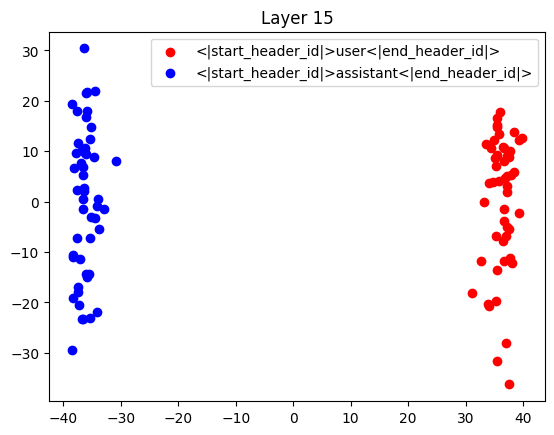

In [27]:
LAYER = 15 
plot_pca(acts["user"][LAYER], acts["assistant"][LAYER], f"Layer {LAYER}")

## Mean difference vector

In [28]:
vectors = {}
for layer in tqdm(range(model.n_layers)):
    user = torch.tensor(acts["user"][layer])
    assistant = torch.tensor(acts["assistant"][layer])
    mean_diff = assistant.mean(dim=0) - user.mean(dim=0)
    vectors[layer] = mean_diff

100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


## Test steering

In [51]:
LAYER = 10
results = model.generate_with_steering(
    text=[
        tokenizer.chat_format(
            [
                {"role": "user", "content": "Tell me about yourself"},
            ],
            add_generation_prompt=True,
        )
    ],
    tokenizer=tokenizer,
    steering_configs=[
        SteeringConfig(
            layer=LAYER,
            scale=-2,
            vector=vectors[LAYER],
            steering_fn=add_multiplier,
            token_location_fn=all_tokens,
        )
    ],
    max_n_tokens=100,
    save_to=None,
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [52]:
print(results['results'][0]['output'])

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me about yourself<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I am a 25-year-old woman who has been living in a small town in the United States. She is a 5th grader in a school that has a school play about a character named "Luna" who is a 12-year-old girl who is a 5th gr


In [53]:
results = model.generate_with_steering(
    text=[
        tokenizer.chat_format(
            [
                {"role": "user", "content": "Tell me about yourself"},
            ],
            add_generation_prompt=True,
        )
    ],
    tokenizer=tokenizer,
    steering_configs=[
        SteeringConfig(
            layer=LAYER,
            scale=2,
            vector=vectors[LAYER],
            steering_fn=add_multiplier,
            token_location_fn=all_tokens,
        )
    ],
    max_n_tokens=100,
    save_to=None,
)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [54]:
print(results['results'][0]['output'])

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me about yourself<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm an AI, and I'm here to help. I'm a large language model, trained on a massive dataset of text. I can process and generate human-like responses to a wide range of topics and questions. I'm constantly learning and improving, and I'm happy to chat with you about
